# Understanding and Predicting Property Maintenance Fines

**Note**: This information is taken directly from the Notebook for the Coursera Course: Applied Machine Learning in Python. All code/writing that follow this section are mine.

This project is based on a data challenge from the Michigan Data Science Team (MDST).

The Michigan Data Science Team (MDST) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences (MSSISS) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the Detroit Open Data Portal. Only the data already included in your Coursera directory can be used for training the model for this assignment. Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

    Building Permits
    Trades Permits
    Improve Detroit: Submitted Issues
    DPD: Citizen Complaints
    Parcel Map

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.


File descriptions (Use only this data for training your model!)

readonly/train.csv - the training set (all tickets issued 2004-2011)
readonly/test.csv - the test set (all tickets issued 2012-2016)
readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
 Note: misspelled addresses may be incorrectly geolocated.


Data fields

train.csv & test.csv

ticket_id - unique identifier for tickets
agency_name - Agency that issued the ticket
inspector_name - Name of inspector that issued the ticket
violator_name - Name of the person/organization that the ticket was issued to
violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
ticket_issued_date - Date and time the ticket was issued
hearing_date - Date and time the violator's hearing was scheduled
violation_code, violation_description - Type of violation
disposition - Judgment and judgement type
fine_amount - Violation fine amount, excluding fees
admin_fee - $20 fee assigned to responsible judgments

state_fee - $10 fee assigned to responsible judgments late_fee - 10% fee assigned to responsible judgments discount_amount - discount applied, if any clean_up_cost - DPW clean-up or graffiti removal cost judgment_amount - Sum of all fines and fees grafitti_status - Flag for graffiti violations

train.csv only

payment_amount - Amount paid, if any
payment_date - Date payment was made, if it was received
payment_status - Current payment status as of Feb 1 2017
balance_due - Fines and fees still owed
collection_status - Flag for payments in collections
compliance [target variable for prediction] 
 Null = Not responsible
 0 = Responsible, non-compliant
 1 = Responsible, compliant
compliance_detail - More information on why each ticket was marked compliant or non-compliant


Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using readonly/train.csv. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from readonly/test.csv will be paid, and the index being the ticket_id.

# Exploratory Data Analysis
In this section, we will take a first look at the training data provided. Here are some basic questions we would like to answer in this section: 
1. What is the distribution of the target values? 
2. Are there any nulls values in the data? 
3. Are there any features that could contribute to data leakage? 
4. Within the features, which ones can we confidently drop (without further analysis)? 
5. What feature types are we working with?  
Answers to all of these questions will influence our decisions in the feature engineering stage. 


In [1]:
import numpy as np

import pandas as pd

train_data = pd.read_csv('train.csv', engine='python')

outcomes = train_data['compliance']

In [23]:
outcomes_responsible = outcomes.dropna()
print(outcomes_responsible.mean()*100)

7.2535651738804106


From this, we see that only $7.25\%$ of the tickets issued were paid. We are dealing with an imbalanced dataset, and as such, classification will not be a good metric for judging model performance. 

In [24]:
print(train_data.isnull().sum())

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250303
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_amount                     0
b

There are many features containing null variables, however, not all of these features will be important, we'll come back to this later when we are doing some feature engineering. 

The following columns contain future information that would not be available when the ticket is issued. Most of these are proxies for the target value. 


In [25]:
future_information = ['payment_amount','balance_due','payment_date','payment_status','compliance_detail','grafitti_status','collection_status']

Now, we can look at which features are highly unpredictive, as in, which features we can drop without doing any further analysis on them. 


In [26]:
features_to_drop = ['inspector_name','violator_name','non_us_str_code','country','violation_zip_code','mailing_address_str_number','mailing_address_str_name','zip_code','ticket_issued_date','agency_name']

Of the remaining features, they are a mix of continuous and categorical. The main categorical features we will be dealing with is the $\texttt{violation_code}/\texttt{violation_description}$ feature and $\texttt{agency_name}$. These contains information about the type of infraction. When engineering the features, we should encode these categorically. 

Let's try and get a preliminary list of features that will be used in our model: 

In [27]:
features_to_use = ['judgment_amount','violation_code','disposition']

This is a pretty small list of features! However, there is room to do some feature creation to get more predictive features. Some ideas include: 
1. Neighbourhood of property violation. 
2. Has this property had previous violations? 
3. Could there be some relation with the hearing date and compliance (people can't miss work, etc)?

# Data Cleansing
Before moving forward with implementing a model and engineering features, we first need to deal with the following issues:
1. Dropping all previous features discussed.
2. Dropping all NaNs (when applicable)

First, let's just drop all the features we discussed above. 

In [28]:
train_data = train_data.drop(columns = future_information)
train_data = train_data.drop(columns = features_to_drop)

In [29]:
train_data = train_data[train_data['compliance'].notna()]
compliance = train_data['compliance']

# Feature Engineering 
Let's try adding a feature counting the number of infractions per address. 

In [30]:
train_data['violation_street_number'] = train_data['violation_street_number'].astype(str) + train_data['violation_street_name']

In [31]:
train_data['Infraction Counts'] = train_data.groupby(['violation_street_number'])['violation_street_name'].transform('count')

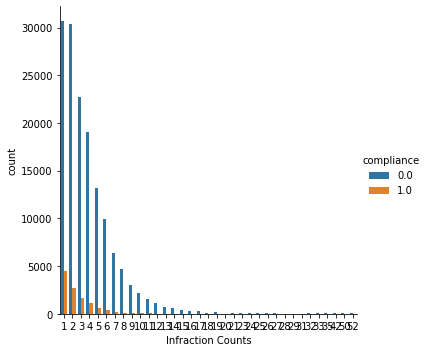

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.catplot(x = 'Infraction Counts', hue = 'compliance', kind = 'count', data = train_data)

Nice! This looks like it could be a good feature. Note that After 10 infractions or so, we only have non-compliances. We also have data regarding the location of the properties given to us in two files, $\texttt{addresses.csv}$ and $\texttt{latlons.csv}$. Let's load these in and try joining them to our features to see if these will give us any information. Could try doing a cluster plot with lat vs lon or smth like that...


In [33]:
address =  pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')
address = address.set_index('address').join(latlons.set_index('address'), how='left')
train_data = train_data.set_index('ticket_id').join(address.set_index('ticket_id'))

In [34]:
train_data

,violation_street_number,violation_street_name,city,state,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,Infraction Counts,lat,lon
ticket_id,,,,,,,,,,,,,,,,,,,
22056,2900.0TYLER,TYLER,CHICAGO,IL,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,5,42.390729,-83.124268
27586,4311.0CENTRAL,CENTRAL,Detroit,MI,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0,1,42.326937,-83.135118
22046,6478.0NORTHFIELD,NORTHFIELD,LOG BEACH,CA,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,2,42.145257,-83.208233
18738,8027.0BRENTWOOD,BRENTWOOD,Clinton,MI,2005-02-22 15:00:00,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,2,42.433466,-83.023493
18735,8228.0MT ELLIOTT,MT ELLIOTT,Detroit,MI,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,3,42.388641,-83.037858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285106,20009.0NORTHLAWN,NORTHLAWN,DETROIT,MI,2012-02-03 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,0.0,1,42.440228,-83.154829
284650,15725.0STEEL,STEEL,DETROIT,MI,2012-01-09 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,0.0,4,42.406293,-83.171850
285125,7152.0CHICAGO,CHICAGO,DETROIT,MI,2012-01-25 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,500.0,20.0,10.0,50.0,0.0,0.0,580.0,0.0,1,42.366529,-83.141897


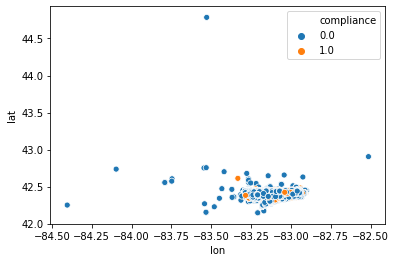

In [35]:
%matplotlib inline
sns.scatterplot(x = 'lon', y='lat', hue='compliance',data = train_data)

From this visualization, we can see that there are "clusters" of locations were there are more compliant violations than non-compliant violations!

Now, we drop all the remaining features we don't need:

In [36]:
to_drop = ['fine_amount','admin_fee','state_fee','late_fee','discount_amount','clean_up_cost','violation_street_number','violation_street_name','violation_description','city','state','hearing_date','disposition']
train_data = train_data.drop(columns = to_drop)
train_data = train_data.dropna()
target_train = train_data['compliance']
train_data = train_data.drop('compliance',axis=1)

train_data = pd.get_dummies(train_data, columns  = ['violation_code'])



In [37]:
train_data

,judgment_amount,Infraction Counts,lat,lon,violation_code_19420901,violation_code_19450901,violation_code_19830901,violation_code_19840901,violation_code_19850901,violation_code_20130901,...,violation_code_9-1-81(a),violation_code_9-1-81(b),violation_code_9-1-81(e),violation_code_9-1-82(b),violation_code_9-1-82(d) - (Buildin,violation_code_9-1-82(d) - (Dwellin,violation_code_9-1-82(d) - (Structu,violation_code_9-1-83 - (Building 5,violation_code_9-1-83 - (Dwelling),violation_code_9-1-83 - (Structures
ticket_id,,,,,,,,,,,,,,,,,,,,,
22056,305.0,5,42.390729,-83.124268,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27586,855.0,1,42.326937,-83.135118,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22046,305.0,2,42.145257,-83.208233,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18738,855.0,2,42.433466,-83.023493,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18735,140.0,3,42.388641,-83.037858,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285106,250.0,1,42.440228,-83.154829,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
284650,1130.0,4,42.406293,-83.171850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
285125,580.0,1,42.366529,-83.141897,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
target_train

ticket_id
22056     0.0
27586     1.0
22046     0.0
18738     0.0
18735     0.0
         ... 
285106    0.0
284650    0.0
285125    0.0
284881    1.0
284333    0.0
Name: compliance, Length: 159878, dtype: float64

# Model Selection and Training
With our features chosen and our data (relatively) cleaned, we can now begin impleneting a predictive model on the data.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(train_data, target_train, random_state=0)

## Sanity Check
Let's try a dummy classifier on the data and see what happens.

In [40]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
accuracy = dummy_clf.score(X_test,y_test)
recall = recall_score(y_test,y_pred)
print(accuracy,recall)

0.92694520890668 0.0


Hey that's a pretty good accuracy! But the recall is 0.0. Remember that since we are dealing with highly imbalanced classes, working with accuracy alone is not a good metric. 

## Logistic Regression
This is a standard implementation of logistic regression with regularization. We use $\texttt{𝙶𝚛𝚒𝚍𝚂𝚎𝚊𝚛𝚌𝚑𝙲𝚅}$ to optimize the regularization parameter.

C:\Users\Ben\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AUC: 0.6802019069010778 Accuracy: 0.9269952464348261


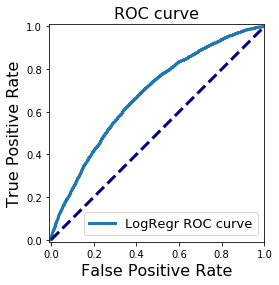

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

X_train, X_test, y_train, y_test = train_test_split(train_data_scaled, target_train, random_state=0)
#Scaling features for regularization

logist = LogisticRegression(C=5)
logist.fit(X_train,y_train)    
y_score_lr = logist.decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)

print('AUC:', auc(fpr_lr, tpr_lr),'Accuracy:', logist.score(X_test,y_test))

%matplotlib inline
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')


# Tree Based Models
In addition, we use both a random forest and a gradient boosted decision tree for classification. 

## Random Forest
We run $\texttt{GridSearchCV}$ in the $\texttt{RFModel.py}$ file on the following key parameters:$\texttt{max_features},\texttt{min_samples_split},\texttt{n_estimators}$ and use the best parameter values here. 

AUC: 0.7763144122159984 Accuracy: 0.9259694771078308


C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


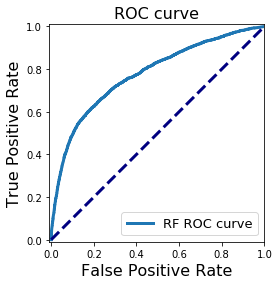

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(train_data, target_train, random_state=0)
rf = RandomForestClassifier(n_jobs = -1, max_features = 'auto', min_samples_split = 12, n_estimators = 1200)
rf.fit(X_train,y_train)

y_score_prob = rf.predict_proba(X_test)
probs = y_score_prob[:,1]


fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, probs)
print('AUC:', auc(fpr_rf, tpr_rf), 'Accuracy:', rf.score(X_test,y_test))
%matplotlib inline
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=3, label='RF ROC curve')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')


## Gradient Boosted Decision Trees
We use the gradient boosted classifier included in Sklearn. First, with default parameters. 

AUC: 0.7903070452738802 Accuracy: 0.9283712784588442


C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


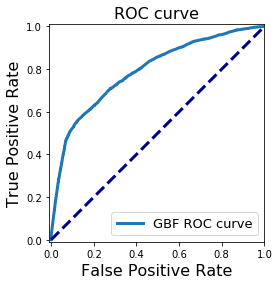

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

X_train, X_test, y_train, y_test = train_test_split(train_data, target_train, random_state=0)

gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

y_score_prob = gb.predict_proba(X_test)


probs = y_score_prob[:,1]


fpr_gb, tpr_gb, thresholds = metrics.roc_curve(y_test, probs)
print('AUC:', auc(fpr_gb, tpr_gb), 'Accuracy:', gb.score(X_test,y_test))
%matplotlib inline
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_gb, tpr_gb, lw=3, label='GBF ROC curve')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')

Using $\texttt{GridSearchCV}$ we search for optimal values for the key parameters: $\texttt{n_estimators},\texttt{max_depth},\texttt{learning_rate}$ 

AUC: 0.8027109515094375 Accuracy: 0.9268451338503878


C:\Users\Ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


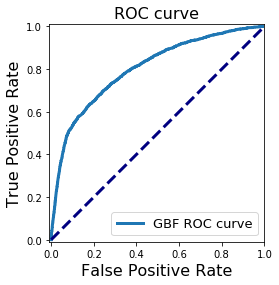

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

X_train, X_test, y_train, y_test = train_test_split(train_data, target_train, random_state=0)

gb = GradientBoostingClassifier(n_estimators = 350, max_depth = 5, learning_rate = 0.1)
gb.fit(X_train,y_train)

y_score_prob = gb.predict_proba(X_test)


probs = y_score_prob[:,1]


fpr_gb, tpr_gb, thresholds = metrics.roc_curve(y_test, probs)
print('AUC:', auc(fpr_gb, tpr_gb), 'Accuracy:', gb.score(X_test,y_test))
%matplotlib inline
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_gb, tpr_gb, lw=3, label='GBF ROC curve')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')

# Going forward

## Model Improvements
To improve this model further, we could experiment with the following: 
1. Further feature engineering and cleansing (this could include dropping correlated features and adding some new ones)
2. Replacing GradientBoostingClassifier with XGBoost (this was not within the scope of the assignment so it was never tried)
3. Stacking our two strongest classifiers (RandomForestClassifier and GradientBoostingClassifier) to improve the results
4. We could scrape more data for this project using the Open Data Portals

## Model Limitations
The most significant limitation I encountered was in the recording of the violation description and the violation code. Given that this is entered manually at the time of the infraction, there is the chance that there are typos in this information. 

In addition, this model would have to be retrained every time new violation codes are created. This is something that we actually enconter as there are some disrecpencies between the train and test set involving this. 